In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import math
import random
import pandas as pd

import scipy as sp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import dgl
import dgl.nn as dglnn

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from collections import OrderedDict

from torch import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.utils.data._utils.collate import default_collate

from tqdm import tqdm
from dataset import ETTDataset, ETT_SPLIT

import warnings
warnings.simplefilter("ignore")

In [3]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dteakhperky (dteakhperky-higher-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

    generator = torch.Generator()
    generator.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [6]:
SEED = 0xBAD5EED
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Graph building functions

In [7]:
def compute_ess(x_series: np.ndarray, y_series: np.ndarray) -> float:
    """
    Calculates effective sample size for two time series (https://arxiv.org/pdf/2401.02387).
    :param x_series: X time series data
    :param y_series: Y time series data
    :returns: effective sample size
    """
    n = x_series.shape[0]
    x_dot = np.diff(x_series)
    y_dot = np.diff(y_series)
    ess = n * np.sqrt((np.var(x_dot) + np.var(y_dot)) / (2.0 * np.pi))
    return ess

def correlation_ess_estimation(x_series: np.ndarray, y_series: np.ndarray) -> float:
    """
    Estimates correlation between time series X and Y based on effective sample size (https://arxiv.org/pdf/2401.02387).
    :param x_series: X time series data
    :param y_series: Y time series data
    :returns: test statistic
    """
    n = x_series.shape[0]
    r, _ = sp.stats.pearsonr(x_series, y_series)
    ess = min(compute_ess(x_series, y_series), n)
    return np.sqrt(max(ess - 3, 0)) * np.atanh(r)

def ess_adjusted_pvalue_matrix(time_series: np.ndarray) -> np.ndarray:
    """
    Computes a matrix of ESS-adjusted p-values for pairwise correlations between time series components.
    The p-values test the null hypothesis that the true correlation is zero, accounting for autocorrelation.
    :param time_series: multivariate time series (n_samples, n_components)
    :returns: symmetric matrix of p-values of shape (n_components, n_components)
    """
    n_components = time_series.shape[1]
    pvalue_matrix = np.zeros((n_components, n_components))
    for i in range(n_components):
        for j in range(i + 1, n_components):
            test_stat = correlation_ess_estimation(time_series[:, i], time_series[:, j])
            p_value = 2 * sp.stats.norm.cdf(-np.abs(test_stat))
            pvalue_matrix[i, j] = p_value
            pvalue_matrix[j, i] = p_value

    return pvalue_matrix

In [8]:
def build_graph(time_series: np.ndarray, alpha: float = 0.05) -> dgl.graph:
    """
    Constructs graph of time series components based on alpha confidence level.
    :param time_series: multivariate time series (n_samples, n_components)
    :param alpha: confidence level
    :returns: constructed graph of components
    """
    n_components = time_series.shape[1]
    pvalues_matrix = ess_adjusted_pvalue_matrix(time_series)
    src_nodes, dst_nodes = np.where(pvalues_matrix <= alpha)
    return dgl.graph((src_nodes, dst_nodes), num_nodes=n_components)

# Dataset setup

In [9]:
ALPHA = 0.05
HORIZON_SIZE = 24
LOOKBACK_SIZE = 96

BATCH_SIZE = 64
NUM_WORKERS = 4

TOTAL_NUM_NODES = 7
TGT_COMP_IDX = TOTAL_NUM_NODES - 1

DATASET_NAME = "ETTh1.csv"

In [10]:
from dataset import get_datasets

train_ds, val_ds, test_ds = get_datasets(
    dataset_name=DATASET_NAME,
    lookback_size=LOOKBACK_SIZE,
    horizon_size=HORIZON_SIZE
)

In [11]:
class CustomGraphDataset(Dataset):
    def __init__(self, dataset: ETTDataset, alpha: float = 0.05):
        super().__init__()
        self.graphs: list[dgl.DGLGraph] = []
        self.targets: list[torch.Tensor] = []
        self.times: list[torch.Tensor] = []
        for idx in tqdm(range(len(dataset)), desc="Building graphs"):
            x_time, x_data, y_data = dataset[idx]
            graph = build_graph(x_data, alpha=alpha)
            graph.ndata["h"] = x_data.T
            self.targets.append(y_data.T[TGT_COMP_IDX])
            self.times.append(x_time)
            self.graphs.append(graph)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx) -> tuple[dgl.DGLGraph, torch.Tensor]:
        return self.times[idx], self.graphs[idx], self.targets[idx]

In [12]:
def graph_collate_fn(batch):
    """
    Custom collate function for batching DGL graphs.
    :param graphs: batch of graphs and targets
    :returns: batched graph, batch of targets
    """
    batch_size = len(batch)
    times, graphs, targets = zip(*batch)
    horizon_size = targets[0].shape[0]
    lookback_size, n_features = times[0].shape
    times_tensor = torch.zeros((batch_size, lookback_size, n_features))
    targets_tensor = torch.zeros((batch_size, horizon_size))
    for idx in range(batch_size):
        targets_tensor[idx, :] = targets[idx]
        times_tensor[idx, :, :] = times[idx]

    return times_tensor, dgl.batch(graphs), targets_tensor

In [13]:
train_ds = CustomGraphDataset(train_ds, alpha=ALPHA)
val_ds = CustomGraphDataset(val_ds, alpha=ALPHA)
test_ds = CustomGraphDataset(test_ds, alpha=ALPHA)

Building graphs:   0%|          | 7/8641 [00:00<02:06, 68.33it/s]

Building graphs: 100%|██████████| 2761/2761 [00:36<00:00, 75.04it/s]


In [14]:
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    collate_fn=graph_collate_fn,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    collate_fn=graph_collate_fn,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    collate_fn=graph_collate_fn,
    drop_last=True
)

In [15]:
dataframe = pd.read_csv(Path(os.getcwd()).parent / "datasets" / DATASET_NAME)
full_val_ts = dataframe[dataframe.date.between(*ETT_SPLIT.val)].drop(columns="date").values
full_test_ts = dataframe[dataframe.date.between(*ETT_SPLIT.test)].drop(columns="date").values
full_train_ts = dataframe[dataframe.date.between(*ETT_SPLIT.train)].drop(columns="date").values

# Visualizations

In [16]:
def plot_graph(graph, title="Graph illustration"):
    plt.figure(figsize=(8, 5))
    plt.title(title + f" ({graph.num_edges()} edges)")
    g = graph.to_networkx().to_undirected()
    pos = nx.spring_layout(g)
    node_labels = {idx: label for idx, label in enumerate(["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"])}
    node_colors = ["red" if i == TGT_COMP_IDX else "skyblue" for i in range(graph.num_nodes())]
    nx.draw(g, pos, with_labels=True, labels=node_labels, node_color=node_colors, node_size=1000)

In [17]:
batched_graph = next(iter(train_loader))[1]
g1, g2, g3, *_ = dgl.unbatch(batched_graph)

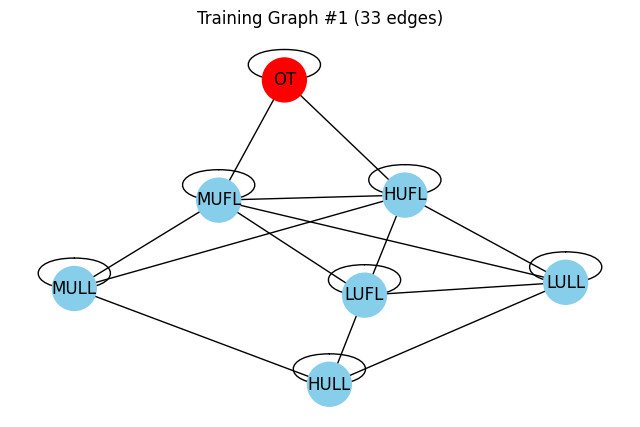

In [18]:
plot_graph(g1, "Training Graph #1")

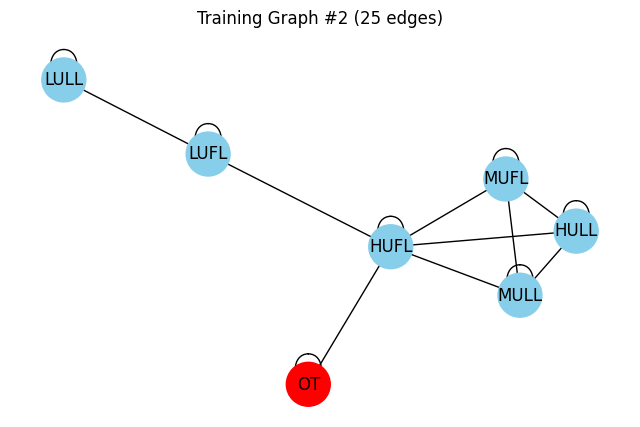

In [19]:
plot_graph(g2, "Training Graph #2")

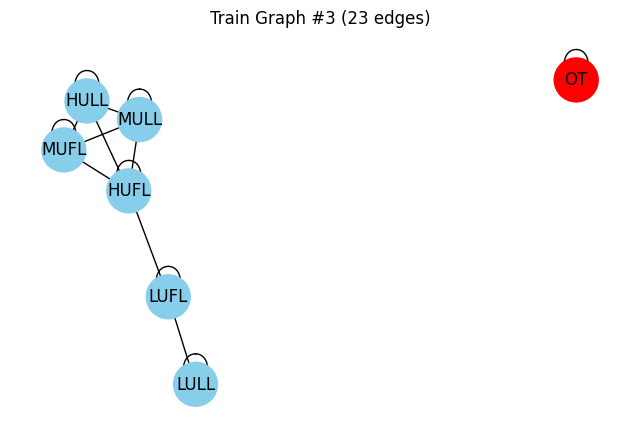

In [20]:
plot_graph(g3, "Train Graph #3")

# Model Setup

In [21]:
class GCNBlock(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, activation: nn.Module, residual: bool = True, dropout: float = 0):
        super().__init__()
        self.residual = residual
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.dropout = dropout

        self.norm = nn.LayerNorm(input_dim)
        self.gcn = dglnn.GraphConv(
            in_feats=self.input_dim,
            out_feats=self.hidden_dim,
            activation=self.activation()
        )
        self.dropout = nn.Dropout(self.dropout)
        if self.residual and self.input_dim != self.hidden_dim:
            self.skip = nn.Linear(self.input_dim, self.hidden_dim)
        if self.residual and self.input_dim == self.hidden_dim:
            self.skip = nn.Identity()

    def forward(self, graph, features):
        outputs = self.norm(features)
        outputs = self.gcn(graph, outputs)
        outputs = self.dropout(outputs)
        if self.residual:
            outputs = outputs + self.skip(features)

        return outputs

In [22]:
class GCNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, activation: nn.Module, residual: bool = True, dropout: float = 0):
        super().__init__()
        self.residual = residual
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.activation = activation
        self.dropout = dropout
        
        self.blocks = nn.ModuleList()
        for i in range(num_layers):
            self.blocks.append(GCNBlock(
                input_dim=self.input_dim if i == 0 else self.hidden_dim,
                hidden_dim=self.hidden_dim,
                activation=self.activation,
                residual=self.residual,
                dropout=self.dropout
            ))
    
    def forward(self, graph, features):
        outputs = features
        for block in self.blocks:
            outputs = block(graph, outputs)
        
        return outputs

In [23]:
class Encoding(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        weight = torch.zeros(self.input_dim, self.output_dim, requires_grad=False).float()
        pos_enc = torch.arange(0, self.input_dim).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.output_dim, 2).float() * -(math.log(10000.0) / self.output_dim))

        weight[:, 0::2] = torch.sin(pos_enc * div_term)
        weight[:, 1::2] = torch.cos(pos_enc * div_term)

        self.embeddings = nn.Embedding(self.input_dim, self.output_dim)
        self.embeddings.weight = nn.Parameter(weight, requires_grad=False) # not learnable

    def forward(self, x):
        return self.embeddings(x).detach()

class TimeEncoding(nn.Module):
    def __init__(self, output_dim, learnable: bool = False):
        super().__init__()
        self.output_dim = output_dim
        self.learnable = learnable

        Embedding = Encoding if self.learnable else nn.Embedding
        self.month_embed = Embedding(13, self.output_dim)
        self.weekday_embed = Embedding(7, self.output_dim)
        self.day_embed = Embedding(32, self.output_dim)
        self.hour_embed = Embedding(24, self.output_dim)
        self.minute_embed = Embedding(4, self.output_dim)
    
    def forward(self, x):
        x = x.long()
        month = self.month_embed(x[:, 0, 0])
        weekday = self.weekday_embed(x[:, 0, 1])
        day = self.day_embed(x[:, 0, 2])
        hour = self.hour_embed(x[:, 0, 3])
        minute = self.minute_embed(x[:, 0, 4])
        return month + weekday + day + hour + minute

In [24]:
class GraphTSModel(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        horizon_size: int,
        num_layers: int,
        activation: nn.Module,
        residual: bool = True,
        dropout: float = 0,
        time_learnable: bool = False,
    ):
        super().__init__()
        self.residual = residual
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.activation = activation
        self.dropout = dropout
        self.horizon_size = horizon_size
        self.time_learnable = time_learnable
        
        self.time_emb = TimeEncoding(
            output_dim=self.input_dim,
            learnable=self.time_learnable
        )
        
        self.backbone = GCNModel(
            input_dim=self.input_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            activation=self.activation,
            residual=self.residual,
            dropout=self.dropout
        )
        self.head = nn.Linear(self.hidden_dim, self.horizon_size)
    
    def forward(self, graph, features, time_features):
        time = self.time_emb(time_features)
        time = time.unsqueeze(1).repeat(1, TOTAL_NUM_NODES, 1)
        x = features + time.reshape(-1, features.shape[-1])
        outputs = self.backbone(graph, x)
        tgt_emb = outputs[TGT_COMP_IDX::TOTAL_NUM_NODES] # extract OT's embeddings
        outputs = self.head(tgt_emb)
        return outputs

In [25]:
def test_model_correctness():
    times, g, _ = next(iter(test_loader))
    model = GraphTSModel(
        input_dim=LOOKBACK_SIZE,
        hidden_dim=256,
        horizon_size=HORIZON_SIZE,
        num_layers=3,
        activation=nn.ReLU,
    )
    assert model(g, g.ndata["h"], times).shape[0] == BATCH_SIZE, f"{model(g, g.ndata['h'], times).shape}"
    assert model(g, g.ndata["h"], times).shape[1] == HORIZON_SIZE, f"{model(g, g.ndata['h'], times).shape}"
    print("Seems to be correct!")

In [26]:
test_model_correctness()

Seems to be correct!


# Training setup

In [132]:
def train_step(train_loader, model, optimizer, loss_fn):
    model.train()
    loss_acum = 0
    samples_cnt = 0
    scaler = GradScaler()
    for times, graph, targets in tqdm(train_loader):
        graph = graph.to(device)
        times = times.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        predictions = []
        with autocast(device_type="cuda"):
            for delta in range(HORIZON_SIZE):
                outputs = model(graph, graph.ndata["h"], times)
                loss = loss_fn(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loss_acum += targets.shape[0] * loss.item()
        samples_cnt += targets.shape[0]
        wandb.log({"train_mse": loss.item()})
    
    return {"loss": loss_acum / samples_cnt}

In [133]:
@torch.inference_mode()
def evaluation_step(val_loader, model, loss_fn):
    model.eval()
    loss_acum = 0
    samples_cnt = 0
    for times, graph, targets in tqdm(val_loader):
        graph = graph.to(device)
        times = times.to(device)
        targets = targets.to(device)
        outputs = model(graph, graph.ndata["h"], times)
        loss = loss_fn(outputs, targets)
        loss_acum += targets.shape[0] * loss.item()
        samples_cnt += targets.shape[0]
        wandb.log({"val_mse": loss.item()})

    return {"loss": loss_acum / samples_cnt}

In [134]:
def train(num_epochs, model, optimizer, scheduler, loss_fn, train_loader, val_loader):
    model = model.to(device)
    for epoch in range(1, num_epochs + 1):
        print(f"TRAINING EPOCH={epoch}")

        train_output = train_step(
            train_loader=train_loader,
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn
        )
        val_output = evaluation_step(
            val_loader=val_loader,
            model=model,
            loss_fn=loss_fn
        )
        
        if scheduler is not None:
            scheduler.step()

        print(f"Train Loss: {train_output['loss']}")
        print(f"Validation Loss: {val_output['loss']}")
    
    return None

# Training

In [135]:
g  = next(iter(train_loader))[1]
INPUT_DIM = g.ndata["h"].shape[-1]

In [169]:
HIDDEN_DIM = 768
NUM_LAYERS = 3
RESIDUAL = True
ACTIVATION = nn.ReLU
LEARNABLE = True
DROPOUT = 0.10

model = GraphTSModel(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    horizon_size=TOTAL_NUM_NODES,
    num_layers=NUM_LAYERS,
    activation=ACTIVATION,
    residual=RESIDUAL,
    time_learnable=LEARNABLE,
    dropout=DROPOUT
)

f"Parameters Number: {sum(p.numel() for p in model.parameters()) / 1e6:.3f}M"

'Parameters Number: 1.360M'

In [170]:
WEIGHT_DECAY = 0.0
LEARNING_RATE = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=1e-2, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# scheduler = None
loss_fn = nn.MSELoss()

In [171]:
NUM_EPOCHS = 30

wandb.init(
    project="gnn-ts",
    name="test",
    config={
        "graph_strategy": "local",
        "alpha": ALPHA,
        "model": "GCN",
        "lookback_size": LOOKBACK_SIZE,
        "horizon_size": HORIZON_SIZE,
        "time_usage": "None",
        "input_dim": INPUT_DIM,
        "hidden_dim": HIDDEN_DIM,
        "num_layers": NUM_LAYERS,
        "activation": "ReLU",
        "residual": RESIDUAL,
        "batch_size": BATCH_SIZE,
        "num_epochs": NUM_EPOCHS,
        "weight_decay": WEIGHT_DECAY,
        "learning_rate": LEARNING_RATE,
        "scheduler": "None",
        "optimizer": "AdamW"
    }
)

In [172]:
train(
    num_epochs=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
)

TRAINING EPOCH=1


100%|██████████| 44/44 [00:00<00:00, 60.52it/s]


Train Loss: 39.45280866269712
Validation Loss: 6.530471716414798
TRAINING EPOCH=2


100%|██████████| 44/44 [00:01<00:00, 25.22it/s]


Train Loss: 9.449091734709564
Validation Loss: 4.813221430236643
TRAINING EPOCH=3


100%|██████████| 44/44 [00:01<00:00, 25.63it/s]


Train Loss: 7.9951773290280945
Validation Loss: 4.019433025609363
TRAINING EPOCH=4


100%|██████████| 44/44 [00:01<00:00, 24.28it/s]


Train Loss: 7.331725632702863
Validation Loss: 4.007991529323838
TRAINING EPOCH=5


100%|██████████| 44/44 [00:01<00:00, 24.63it/s]


Train Loss: 6.911847686767578
Validation Loss: 4.131223425269127
TRAINING EPOCH=6


100%|██████████| 44/44 [00:01<00:00, 33.00it/s]


Train Loss: 6.690083394227204
Validation Loss: 3.4956289651719006
TRAINING EPOCH=7


100%|██████████| 44/44 [00:01<00:00, 24.49it/s]


Train Loss: 6.571442720625136
Validation Loss: 3.9314696382392538
TRAINING EPOCH=8


100%|██████████| 44/44 [00:01<00:00, 25.45it/s]


Train Loss: 6.4835111317811185
Validation Loss: 3.529088270935145
TRAINING EPOCH=9


100%|██████████| 44/44 [00:01<00:00, 24.76it/s]


Train Loss: 6.433707495088931
Validation Loss: 4.012087085030296
TRAINING EPOCH=10


100%|██████████| 44/44 [00:01<00:00, 26.24it/s]


Train Loss: 6.339458852344089
Validation Loss: 3.7186159152876246
TRAINING EPOCH=11


100%|██████████| 44/44 [00:01<00:00, 25.38it/s]


Train Loss: 6.236016962263319
Validation Loss: 3.7292308170687067
TRAINING EPOCH=12


100%|██████████| 44/44 [00:01<00:00, 24.98it/s]


Train Loss: 6.2055015405019125
Validation Loss: 3.6810319139198824
TRAINING EPOCH=13


100%|██████████| 44/44 [00:00<00:00, 68.12it/s]


Train Loss: 6.168347697787815
Validation Loss: 3.7820736318826675
TRAINING EPOCH=14


100%|██████████| 44/44 [00:01<00:00, 25.93it/s]


Train Loss: 6.148778463293005
Validation Loss: 3.5669447671283376
TRAINING EPOCH=15


100%|██████████| 44/44 [00:01<00:00, 25.12it/s]


Train Loss: 6.111623264242102
Validation Loss: 3.703132004900412
TRAINING EPOCH=16


100%|██████████| 44/44 [00:01<00:00, 24.22it/s]


Train Loss: 6.071856675324617
Validation Loss: 3.699227598580447
TRAINING EPOCH=17


100%|██████████| 44/44 [00:01<00:00, 23.64it/s]


Train Loss: 6.061354568269517
Validation Loss: 3.850983402945779
TRAINING EPOCH=18


100%|██████████| 44/44 [00:01<00:00, 25.60it/s]


Train Loss: 6.043827650282118
Validation Loss: 3.823400311849334
TRAINING EPOCH=19


100%|██████████| 44/44 [00:01<00:00, 26.46it/s]


Train Loss: 6.053619243480541
Validation Loss: 3.686290540478446
TRAINING EPOCH=20


100%|██████████| 44/44 [00:01<00:00, 22.91it/s]


Train Loss: 6.029461023542616
Validation Loss: 3.9033279689875515
TRAINING EPOCH=21


100%|██████████| 44/44 [00:01<00:00, 24.16it/s]


Train Loss: 5.996102530867965
Validation Loss: 3.8043417659672825
TRAINING EPOCH=22


100%|██████████| 44/44 [00:01<00:00, 25.26it/s]


Train Loss: 5.995688018092403
Validation Loss: 3.6453643346374687
TRAINING EPOCH=23


100%|██████████| 44/44 [00:01<00:00, 25.58it/s]


Train Loss: 5.980677749492504
Validation Loss: 3.7263072349808435
TRAINING EPOCH=24


100%|██████████| 44/44 [00:02<00:00, 21.17it/s]


Train Loss: 5.970604790581597
Validation Loss: 3.80565568940206
TRAINING EPOCH=25


100%|██████████| 44/44 [00:00<00:00, 57.30it/s]


Train Loss: 5.97401871504607
Validation Loss: 3.725999719717286
TRAINING EPOCH=26


100%|██████████| 44/44 [00:00<00:00, 63.83it/s]


Train Loss: 5.9601103146870935
Validation Loss: 3.697046097029339
TRAINING EPOCH=27


100%|██████████| 44/44 [00:01<00:00, 25.07it/s]


Train Loss: 5.95379030086376
Validation Loss: 3.6696182082999838
TRAINING EPOCH=28


100%|██████████| 44/44 [00:01<00:00, 26.33it/s]


Train Loss: 5.95020511591876
Validation Loss: 3.690987692637877
TRAINING EPOCH=29


100%|██████████| 44/44 [00:01<00:00, 25.35it/s]


Train Loss: 5.946431513185854
Validation Loss: 3.79555866393176
TRAINING EPOCH=30


100%|██████████| 44/44 [00:01<00:00, 26.05it/s]

Train Loss: 5.944083812501695
Validation Loss: 3.650365286252715


In [173]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


train_mse,▇█▆▄▅▆▃▃▂▃▃▂▂▁▃▅▃▃▅▅▂▃▃▂▄▃▁▂▃▁▃▄▄▃▄▃▂▂▂▅
val_mse,▃█▂▄▂▁▂▁▂▆▂▂▂▂▂▂▁▂▁▂▂▂▂▂▁▁▂▂▃▂▂▂▂▃▅▁▁▁▂▂
train_mse,6.31556
val_mse,0.59838


# Inference

In [174]:
@torch.inference_mode()
def inference(model, test_loader):
    model.eval()
    loss_acum = 0
    samples_cnt = 0
    for times, graph, targets in tqdm(test_loader):
        graph = graph.to(device)
        times = times.to(device)
        targets = targets.to(device)
        outputs = model(graph, graph.ndata["h"], times)
        loss = F.mse_loss(outputs, targets)
        loss_acum += targets.shape[0] * loss
        samples_cnt += targets.shape[0]
    
    return loss_acum / samples_cnt

In [175]:
inference(model, test_loader)

  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:01<00:00, 26.21it/s]


tensor(3.9751, device='cuda:0')

In [176]:
inference(model, val_loader)

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [00:01<00:00, 25.10it/s]


tensor(3.6504, device='cuda:0')

In [177]:
inference(model, train_loader)

  0%|          | 0/135 [00:00<?, ?it/s]

100%|██████████| 135/135 [00:04<00:00, 30.13it/s]


tensor(5.9081, device='cuda:0')